# JPY Holder Impact

Diego Alvarez <br>
diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")

holders_path = os.path.join(data_path, "tsy_holders.parquet")
hc_path = os.path.join(data_path, "hc.parquet")
eur_path = os.path.join(data_path, "eur_yield.parquet")
jpy_path = os.path.join(data_path, "jpy_yield.parquet")
ust_path = os.path.join(data_path, "tsy_yield.parquet")
usd_jpy_path = os.path.join(data_path, "usd_jpy.parquet")

# Read in Data

In [3]:
df_jpy = (pd.read_parquet(
    path = jpy_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-3:-1]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "JPY"))

df_us = (pd.read_parquet(
    path = ust_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-4:-2]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "USA"))

df_yield = pd.concat([df_jpy, df_us])

df_jpy_hold = (pd.read_parquet(
    path = holders_path, engine = "pyarrow").
    query("security == 'HOLDJN Index'").
    assign(security = lambda x: x.security.str.split(" ").str[0]))

df_usd_jpy = (pd.read_parquet(
    path = usd_jpy_path, engine = "pyarrow")
    [["Adj Close"]])

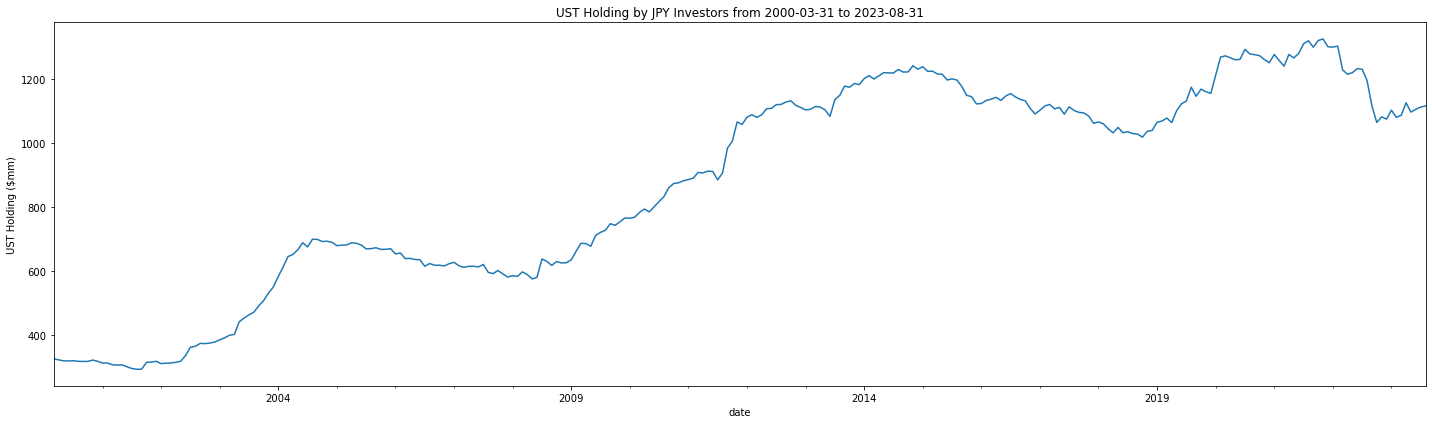

In [4]:
(df_jpy_hold.set_index(
    "date")
    ["PX_LAST"].
    plot(
        figsize = (20,6),
        ylabel = "UST Holding ($mm)",
        title = "UST Holding by JPY Investors from {} to {}".format(
            df_jpy_hold.date.min().date(),
            df_jpy_hold.date.max().date())))

plt.tight_layout()
plt.show()

In [5]:
df_combined = (df_yield.query(
    "country == 'USA'").
    set_index("date").
    resample("M").
    last().
    rename(columns = {"PX_LAST": "yield"}).
    merge(right = df_jpy_hold.rename(columns = {"PX_LAST": "holding"}), how = "inner", on = ["date"]).
    drop(columns = ["country", "security"]).
    assign(holding_shift = lambda x: x.holding.shift(1)).
    dropna())

In [6]:
df_train, df_test = df_combined.query("date < '2015-01-01'"), df_combined.query("date >= '2015-01-01'")

# Regress Yield Against Holding

Established from the last model there is little relationship between hedge yield and Treasury holding, this is also doubled with the fact that FX carry-hedged weighting has negative yield. Therefore its important to find how much yields change with respect to decrease in holding

In [7]:
regression = (sm.OLS(
    endog = df_train["yield"],
    exog = sm.add_constant(df_train["holding"])).
    fit())

alpha, beta = regression.params
rsquared = regression.rsquared

lag_regression = (sm.OLS(
    endog = df_train["yield"],
    exog = sm.add_constant(df_train["holding_shift"])).
    fit())

lag_alpha, lag_beta = lag_regression.params
lag_rsquared = lag_regression.rsquared

x = np.linspace(
    start = df_train.holding.min(),
    stop = df_train.holding.max())

y = (x * beta) + alpha
y_lag = (x * lag_beta) + lag_alpha

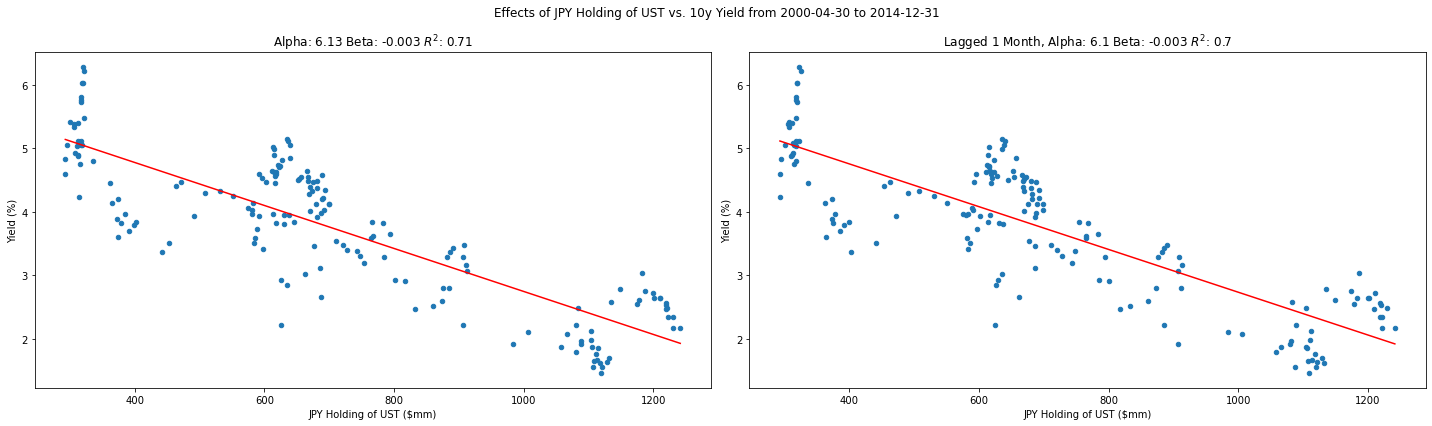

In [8]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_train.plot(
    kind = "scatter",
    x = "holding", y = "yield",
    ax = axes[0],
    title = "Alpha: {} Beta: {} $R^2$: {}".format(
        round(alpha, 2),
        round(beta, 3),
        round(rsquared, 2))))

(df_train.plot(
    kind = "scatter",
    x = "holding_shift", y = "yield",
    ax = axes[1],
    title = "Lagged 1 Month, Alpha: {} Beta: {} $R^2$: {}".format(
        round(lag_alpha, 2),
        round(lag_beta, 3),
        round(lag_rsquared, 2))))

axes[0].plot(x, y, color = "r")
axes[1].plot(x, y_lag, color = "r")

for i in range(2):
    axes[i].set_ylabel("Yield (%)")
    axes[i].set_xlabel("JPY Holding of UST ($mm)")
    
fig.suptitle("Effects of JPY Holding of UST vs. 10y Yield from {} to {}".format(
    df_train.date.min().date(),
    df_train.date.max().date()))

plt.tight_layout()
plt.show()

In [9]:
df_holding_change = ((df_train.set_index("date").pct_change()) * 100).dropna()

In [10]:
regression_change = (sm.OLS(
    endog = df_holding_change["yield"],
    exog = sm.add_constant(df_holding_change["holding"])).
    fit())

alpha_change, beta_change = regression.params
rsquared_change = regression.rsquared

lag_regression_change = (sm.OLS(
    endog = df_holding_change["yield"],
    exog = sm.add_constant(df_holding_change["holding_shift"])).
    fit())

lag_alpha_change, lag_beta_change = lag_regression.params
lag_rsquared_change = lag_regression.rsquared

x_change = np.linspace(
    start = df_holding_change.holding.min(),
    stop = df_holding_change.holding.max())

y_change = (x_change * beta_change) + alpha_change
y_lag_change = (x_change * lag_beta_change) + lag_alpha_change

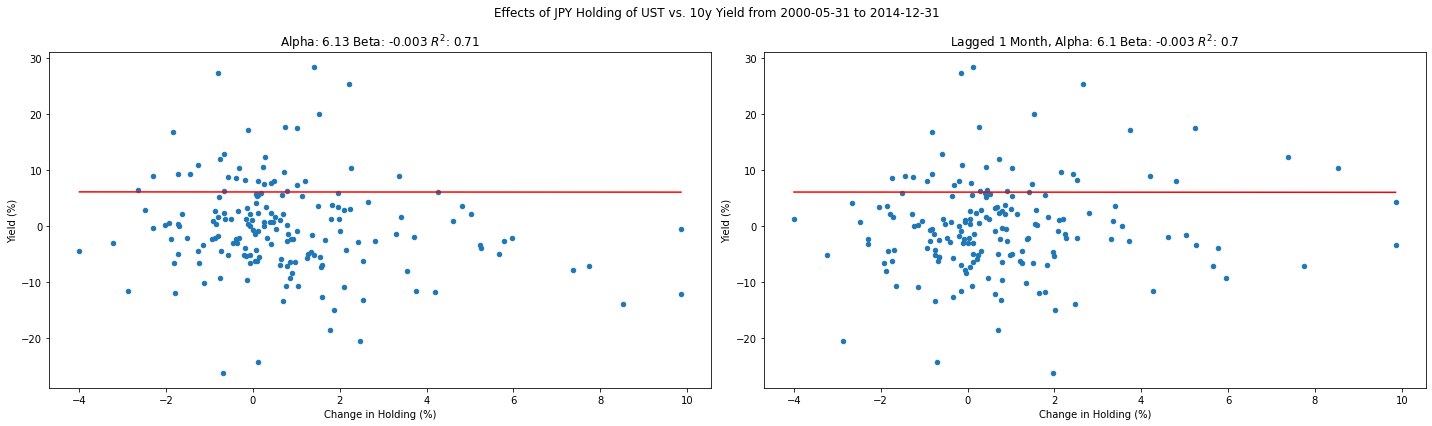

In [11]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_holding_change.plot(
    kind = "scatter",
    x = "holding", y = "yield",
    ax = axes[0],
    title = "Alpha: {} Beta: {} $R^2$: {}".format(
        round(alpha_change, 2),
        round(beta_change, 3),
        round(rsquared_change, 2))))

(df_holding_change.plot(
    kind = "scatter",
    x = "holding_shift", y = "yield",
    ax = axes[1],
    title = "Lagged 1 Month, Alpha: {} Beta: {} $R^2$: {}".format(
        round(lag_alpha_change, 2),
        round(lag_beta_change, 3),
        round(lag_rsquared_change, 2))))

axes[0].plot(x_change, y_change, color = "r")
axes[1].plot(x_change, y_lag_change, color = "r")

for i in range(2):
    axes[i].set_ylabel("Yield (%)")
    axes[i].set_xlabel("Change in Holding (%)")
    
fig.suptitle("Effects of JPY Holding of UST vs. 10y Yield from {} to {}".format(
    df_holding_change.index.min().date(),
    df_holding_change.index.max().date()))

plt.tight_layout()
plt.show()

It appears that from the first regression when JPY investors cut their notional investment yields increase which follows supply and demand price action dynamics, but when comparing changes in holding vs. changes in yields the regression underperforms signficinatly. The possible macroeconomic effect at play could be that yields fell post-Volcker while Japan still increased their treasury exposure. Testing holding against unhedged FX-carry yield will be required as well.

# Through the lens of Historical Rates

The first method will just color the data by date

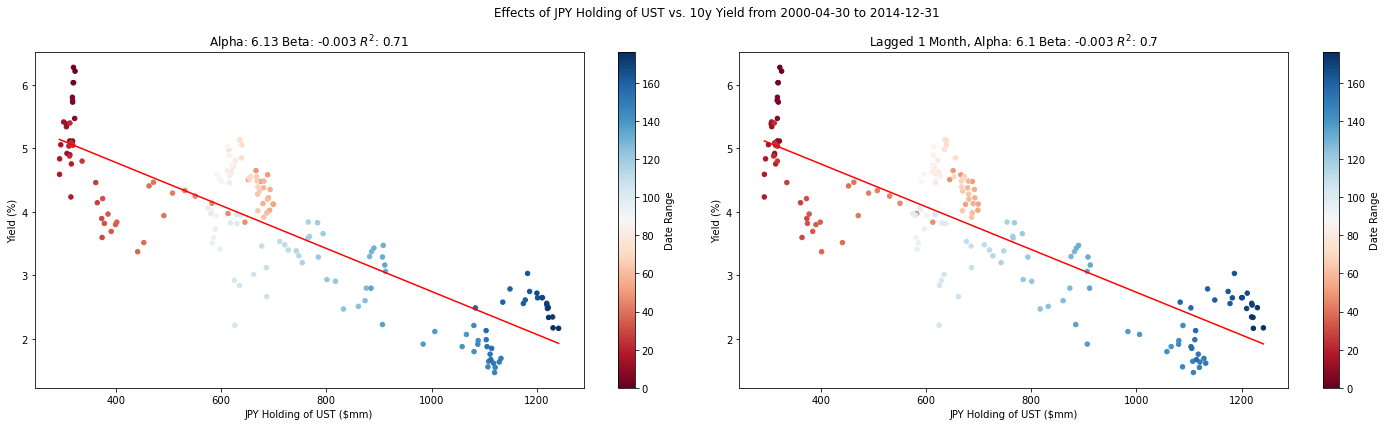

In [23]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_train.
    sort_values("date").
    assign(date_idx = [i for i in range(len(df_train))]).
    rename(columns = {"date_idx": "Date Range"}).
    plot(
        kind = "scatter",
        x = "holding", y = "yield",
        c = "Date Range",
        cmap = "RdBu",
        ax = axes[0],
        title = "Alpha: {} Beta: {} $R^2$: {}".format(
            round(alpha, 2),
            round(beta, 3),
            round(rsquared, 2))))

(df_train.
    sort_values("date").
    assign(date_idx = [i for i in range(len(df_train))]).
    rename(columns = {"date_idx": "Date Range"}).
    plot(
        kind = "scatter",
        x = "holding_shift", y = "yield",
        c = "Date Range",
        cmap = "RdBu",
        ax = axes[1],
        title = "Lagged 1 Month, Alpha: {} Beta: {} $R^2$: {}".format(
            round(lag_alpha, 2),
            round(lag_beta, 3),
            round(lag_rsquared, 2))))

axes[0].plot(x, y, color = "r")
axes[1].plot(x, y_lag, color = "r")

for i in range(2):
    axes[i].set_ylabel("Yield (%)")
    axes[i].set_xlabel("JPY Holding of UST ($mm)")
    
fig.suptitle("Effects of JPY Holding of UST vs. 10y Yield from {} to {}".format(
    df_train.date.min().date(),
    df_train.date.max().date()))

plt.tight_layout()
plt.show()

# Through the lens of price sensitive buyers

Using Rolling Z-Scores as a proxy for richness and cheapness regressing rolling z-scores of yields against JPY Holding will show how price-sensitive JPY investors are. If there is little relationship then that implies that they first regression is more-or-less just an effect of putting more cash to work outside of the country as rates fall. 

In [52]:
df_zscore = (df_yield.query(
    "country == 'USA'").
    drop(columns = ["country"]).
    rename(columns = {"PX_LAST": "rate"}).
    assign(z_score = lambda x: (x.rate - x.rate.rolling(window = 30).mean()) / x.rate.rolling(window = 30).std()).
    dropna().
    rename(columns = {"rate": "yield"}).
    merge(right = df_train, how = "inner", on = ["date", "yield"]).
    assign(holding_change = lambda x: x.holding.pct_change() * 100).
    dropna())

In [53]:
z_score_regression = (sm.OLS(
    endog = df_zscore["holding"],
    exog = sm.add_constant(df_zscore["z_score"])).
    fit())

z_score_alpha, z_score_beta = z_score_regression.params
z_score_rsquared = z_score_regression.rsquared

x = np.linspace(start = df_zscore["z_score"].min(), stop = df_zscore["z_score"].max(), num = 1_000)
y = (x * z_score_beta) + z_score_alpha

z_score_regression_change = (sm.OLS(
    endog = df_zscore["holding_change"],
    exog = sm.add_constant(df_zscore["z_score"])).
    fit())

z_score_alpha_change, z_score_beta_change = z_score_regression_change.params
z_score_rsquared_change = z_score_regression_change.rsquared

x_change = np.linspace(start = df_zscore["z_score"].min(), stop = df_zscore["z_score"].max(), num = 1_000)
y_change = (x_change * z_score_beta_change) + z_score_alpha_change

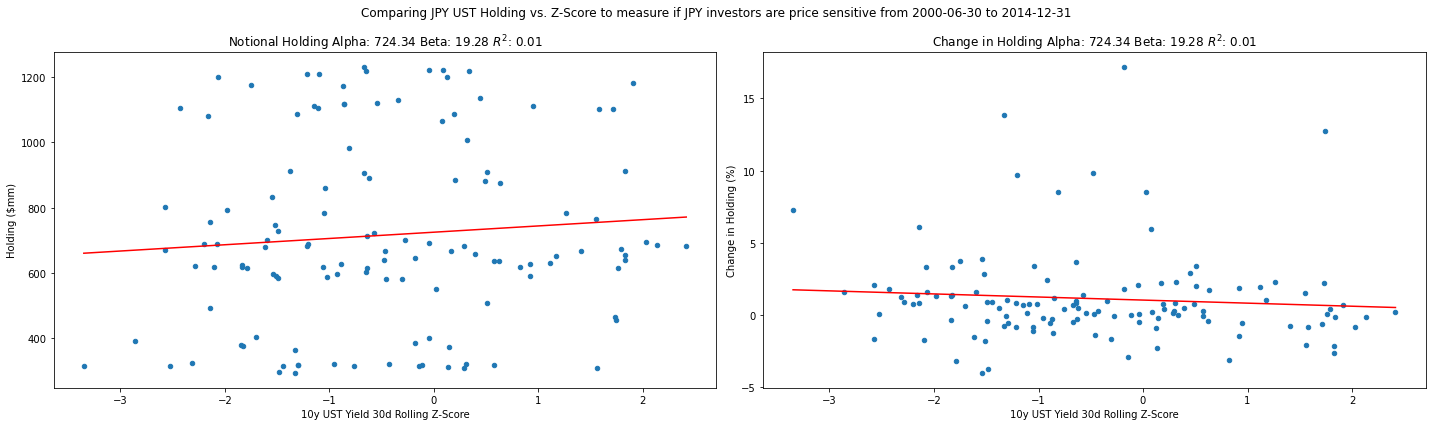

In [60]:
fig, axes = plt.subplots(figsize = (20,6), ncols = 2)

(df_zscore.plot(
    kind = "scatter",
    x = "z_score", y = "holding",
    ax = axes[0],
    xlabel = "10y UST Yield 30d Rolling Z-Score",
    ylabel = "Holding ($mm)",
    title = "Notional Holding Alpha: {} Beta: {} $R^2$: {}".format(
        round(z_score_alpha, 2),
        round(z_score_beta, 2),
        round(z_score_rsquared, 2))))

(df_zscore.plot(
    kind = "scatter",
    x = "z_score", y = "holding_change",
    ylabel = "Change in Holding (%)",
    ax = axes[1],
    xlabel = "10y UST Yield 30d Rolling Z-Score",
    title = "Change in Holding Alpha: {} Beta: {} $R^2$: {}".format(
        round(z_score_alpha, 2),
        round(z_score_beta, 2),
        round(z_score_rsquared, 2))))

axes[0].plot(x,y, color = "r")
axes[1].plot(x_change , y_change, color = "r")
 
fig.suptitle("Comparing JPY UST Holding vs. Z-Score to measure if JPY investors are price sensitive from {} to {}".format(
    df_zscore.date.min().date(),
    df_zscore.date.max().date()))

plt.tight_layout()

# Regression Holding on FX-Unhedged Rate

In [71]:
df_spread = (df_yield.pivot(
    index = "date", columns = ["country"], values = "PX_LAST").
    dropna().
    assign(
        spread = lambda x: x.USA - x.JPY,
        spread_change = lambda x: x.spread.pct_change())
    [["spread", "spread_change"]])

In [75]:
df_train = (df_train.merge(
    right = df_spread, how = "inner", on = ["date"]).
    assign(
        holding_change = lambda x: x.holding.pct_change(),
        holding_change_shift = lambda x: x.holding_change.shift(1)).
    dropna())

Compare notional size vs differential

In [84]:
regression1 = (sm.OLS(
    endog = df_train["spread"],
    exog = sm.add_constant(df_train["holding"])).
    fit())

alpha1, beta1 = regression1.params
rsquared1 = regression1.rsquared

regression2 = (sm.OLS(
    endog = df_train["spread"],
    exog = sm.add_constant(df_train["holding_shift"])).
    fit())

alpha2, beta2 = regression2.params
rsquared2 = regression2.rsquared

x1 = np.linspace(start = df_train["holding"].min(), stop = df_train["holding"].max(), num = 1_000)
y1 = (x1 * beta1) + alpha1

x2 = np.linspace(start = df_train["holding_shift"].min(), stop = df_train["holding_shift"].max(), num = 1_000)
y2 = (x2 * beta2) + alpha2

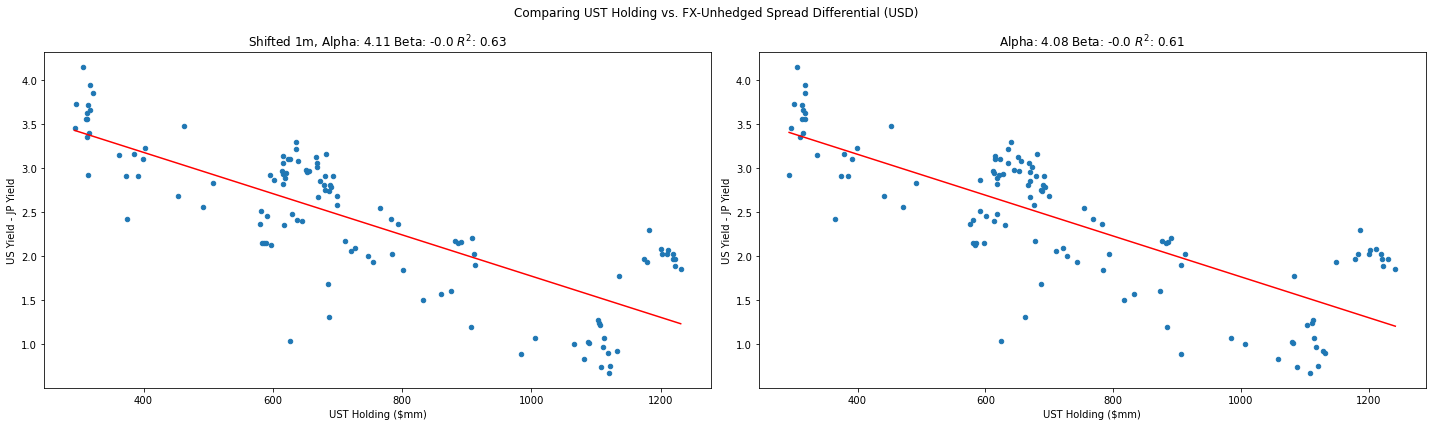

In [88]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_train.plot(
    kind = "scatter",
    ax = axes[0],
    x = "holding",
    y = "spread",
    xlabel = "UST Holding ($mm)",
    ylabel = "US Yield - JP Yield",
    title = "Shifted 1m, Alpha: {} Beta: {} $R^2$: {}".format(
        round(alpha1, 2),
        round(beta1, 2),
        round(rsquared1, 2))))

(df_train.plot(
    kind = "scatter",
    ax = axes[1],
    x = "holding_shift",
    y = "spread",
    xlabel = "UST Holding ($mm)",
    ylabel = "US Yield - JP Yield",
    title = "Alpha: {} Beta: {} $R^2$: {}".format(
        round(alpha2, 2),
        round(beta2, 2),
        round(rsquared2, 2))))

axes[0].plot(x1, y1, color = "r")
axes[1].plot(x2, y2, color = "r")

fig.suptitle("Comparing UST Holding vs. FX-Unhedged Spread Differential (USD)")
plt.tight_layout()
plt.show()

In [91]:
regression1 = (sm.OLS(
    endog = df_train["spread"],
    exog = sm.add_constant(df_train["holding_change"])).
    fit())

alpha1, beta1 = regression1.params
rsquared1 = regression1.rsquared

regression2 = (sm.OLS(
    endog = df_train["spread"],
    exog = sm.add_constant(df_train["holding_change_shift"])).
    fit())

alpha2, beta2 = regression2.params
rsquared2 = regression2.rsquared

x1 = np.linspace(start = df_train["holding_change"].min(), stop = df_train["holding_change"].max(), num = 1_000)
y1 = (x1 * beta1) + alpha1

x2 = np.linspace(start = df_train["holding_change_shift"].min(), stop = df_train["holding_change_shift"].max(), num = 1_000)
y2 = (x2 * beta2) + alpha2

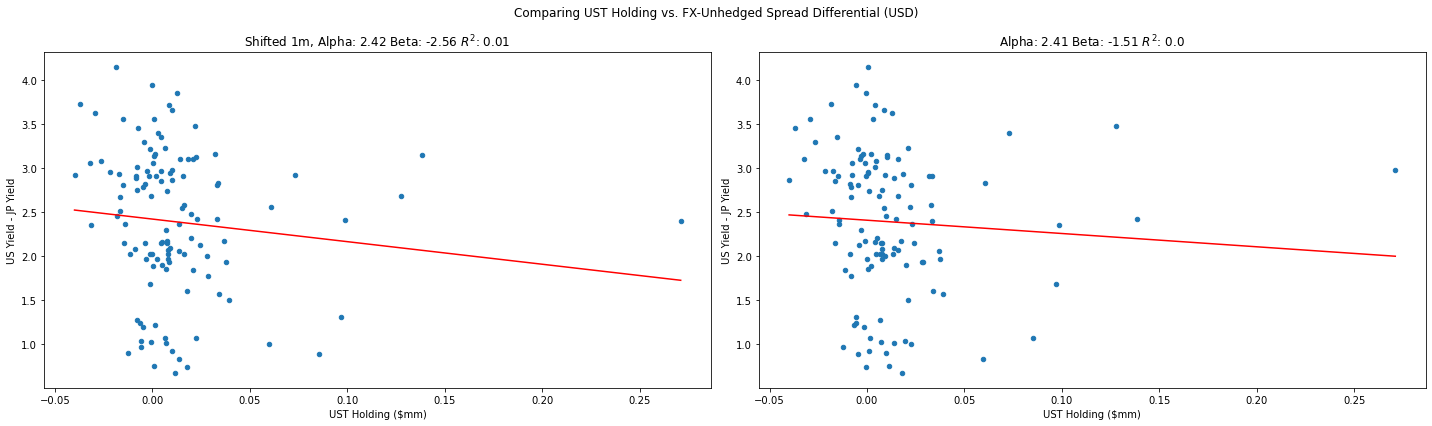

In [92]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_train.plot(
    kind = "scatter",
    ax = axes[0],
    x = "holding_change",
    y = "spread",
    xlabel = "UST Holding ($mm)",
    ylabel = "US Yield - JP Yield",
    title = "Shifted 1m, Alpha: {} Beta: {} $R^2$: {}".format(
        round(alpha1, 2),
        round(beta1, 2),
        round(rsquared1, 2))))

(df_train.plot(
    kind = "scatter",
    ax = axes[1],
    x = "holding_change_shift",
    y = "spread",
    xlabel = "UST Holding ($mm)",
    ylabel = "US Yield - JP Yield",
    title = "Alpha: {} Beta: {} $R^2$: {}".format(
        round(alpha2, 2),
        round(beta2, 2),
        round(rsquared2, 2))))

axes[0].plot(x1, y1, color = "r")
axes[1].plot(x2, y2, color = "r")

fig.suptitle("Comparing UST Holding vs. FX-Unhedged Spread Differential (USD)")
plt.tight_layout()
plt.show()

# Regress Holding Against FX

This will measure how much FX-carry risk JPY investors are taking on, and it should reinforce the statement that many JPY investors are FX-unhedged when buying 10y

In [14]:
(df_usd_jpy.reset_index().rename(
    columns = {
        "Adj Close": "USD_JPY",
        "Date": "date"}).
    merge(right = df_train, how = "inner", on = ["date"]).
    assign(fx_change = lambda x: x.USD_JPY.pct_change()))

,date,USD_JPY,yield,holding,holding_shift,fx_change
0,2000-05-31,107.629997,6.2720,319.4,322.4,NaN
1,2000-06-30,106.010002,6.0310,318.8,319.4,-0.015052
2,2000-07-31,109.330002,6.0310,319.6,318.8,0.031318
3,2000-08-31,106.669998,5.7250,317.8,319.6,-0.024330
4,2000-10-31,108.790001,5.7510,317.7,317.3,0.019874
...,...,...,...,...,...,...
122,2014-06-30,101.443001,2.5304,1219.3,1220.1,-0.010930
123,2014-07-31,102.839996,2.5578,1219.0,1219.3,0.013771
124,2014-09-30,109.389999,2.4888,1221.8,1230.1,0.063691
125,2014-10-31,109.212997,2.3353,1222.4,1221.8,-0.001618
